# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2023 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 17.4.2023

## Initialisation

In [28]:
!pip install corner
!pip install pytransit
!pip install celerite
!pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
%matplotlib inline 

In [30]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile, median, std, pi
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [32]:
tb = Table.read('/content/drive/MyDrive/Máster/Exoplanetas y Exobiología/data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

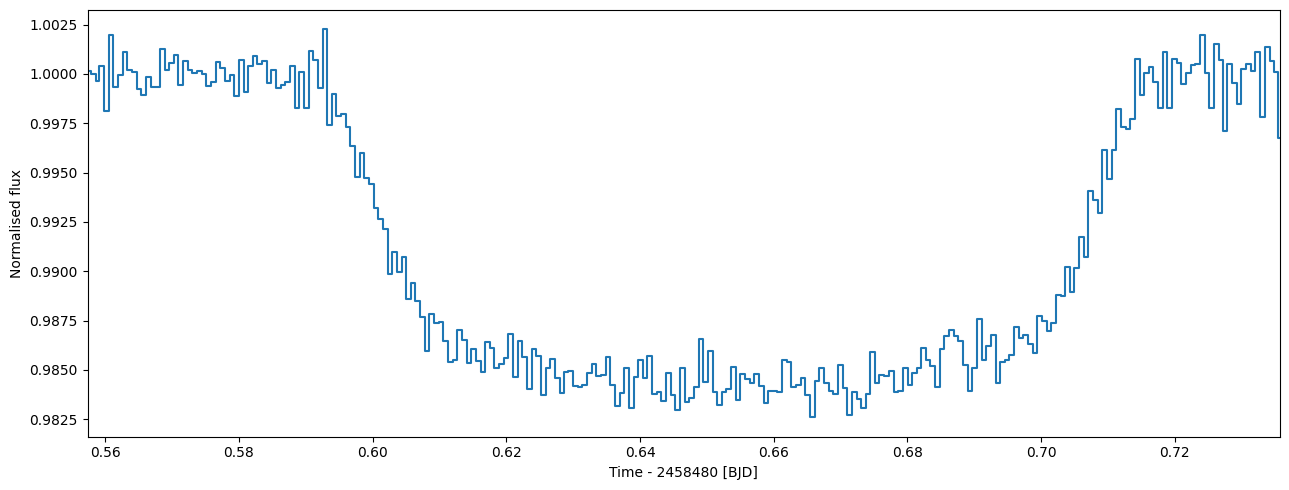

In [33]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [34]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

In [35]:
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [36]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

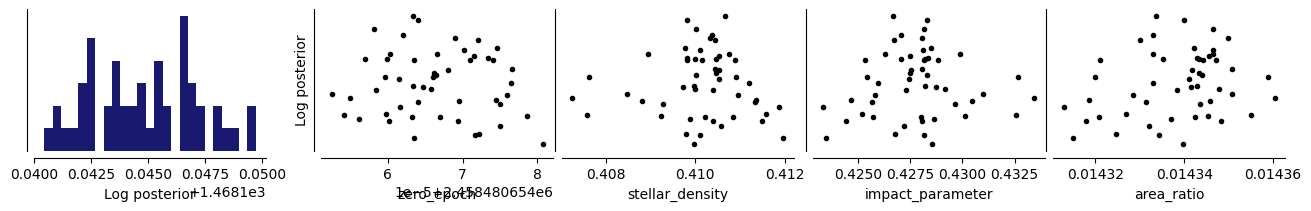

In [37]:
lpf.optimize_global(niter=500, npop=50)

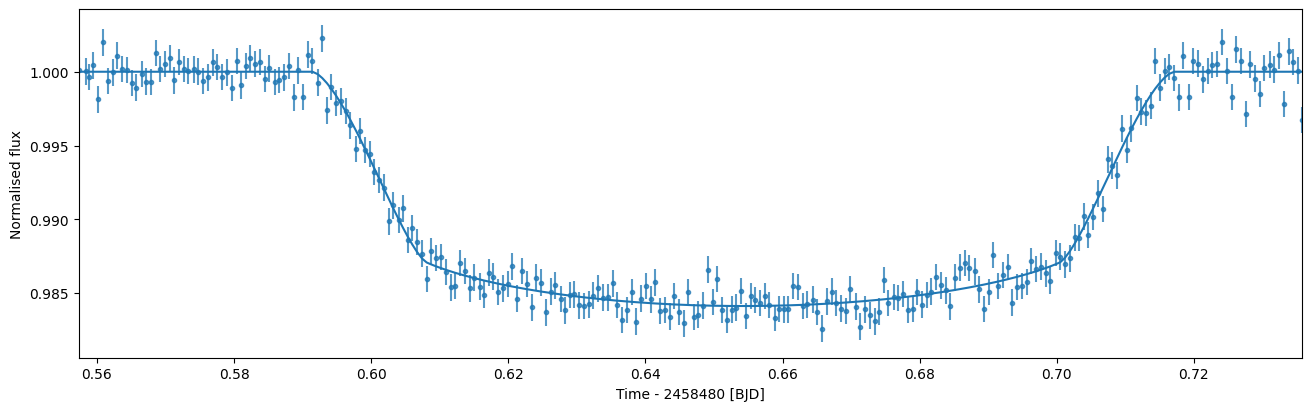

In [38]:
lpf.plot_light_curve();

In [39]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

MCMC sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Run 1/2:   0%|          | 0/5000 [00:00<?, ?it/s]

Run 2/2:   0%|          | 0/5000 [00:00<?, ?it/s]

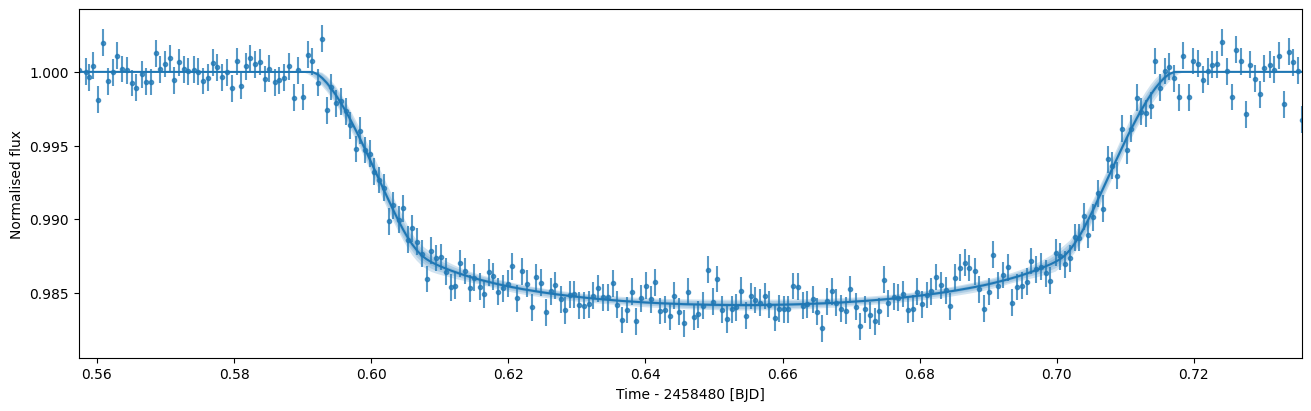

In [40]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

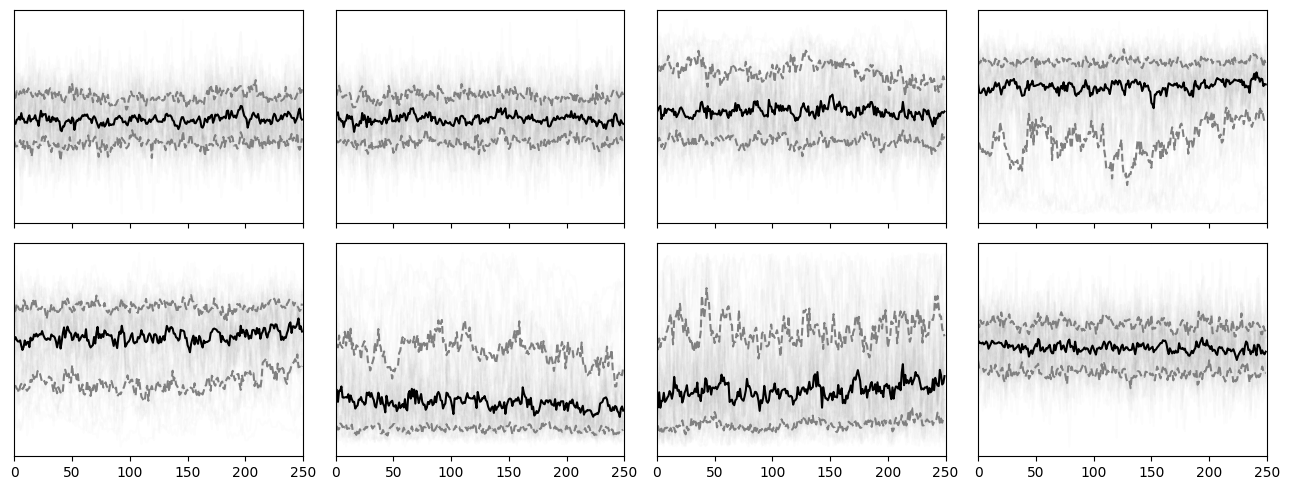

In [41]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [42]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [43]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

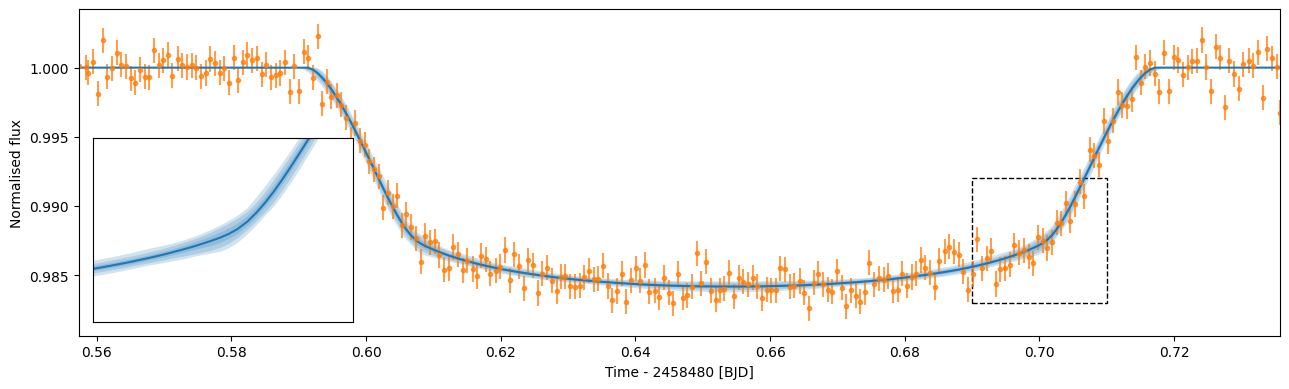

In [44]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [45]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4324,0.3407,0.0140,0.3161,3.4793e-01,-3.0414,0.1182,3.0061,1.4560,0.1258,0.0945
std,1.6205e-04,1.1097e-09,0.0361,0.1246,0.0005,0.2021,2.4258e-01,0.0193,0.0019,0.0836,0.0439,0.0010,0.0026
min,2.4585e+06,1.0914e+00,0.3183,0.0004,0.0127,0.0459,1.9015e-05,-3.1170,0.1126,2.7165,1.3585,0.1226,0.0876
25%,2.4585e+06,1.0914e+00,0.4056,0.2856,0.0137,0.1575,1.5163e-01,-3.0548,0.1169,2.9449,1.4245,0.1252,0.0925
50%,2.4585e+06,1.0914e+00,0.4287,0.3767,0.0140,0.2575,2.9137e-01,-3.0415,0.1185,2.9998,1.4448,0.1258,0.0942
75%,2.4585e+06,1.0914e+00,0.4588,0.4300,0.0143,0.4272,4.9963e-01,-3.0285,0.1197,3.0685,1.4776,0.1265,0.0965
max,2.4585e+06,1.0914e+00,0.5282,0.5723,0.0151,0.9951,9.9919e-01,-2.9680,0.1228,3.2160,1.5707,0.1304,0.1016


<Axes: >

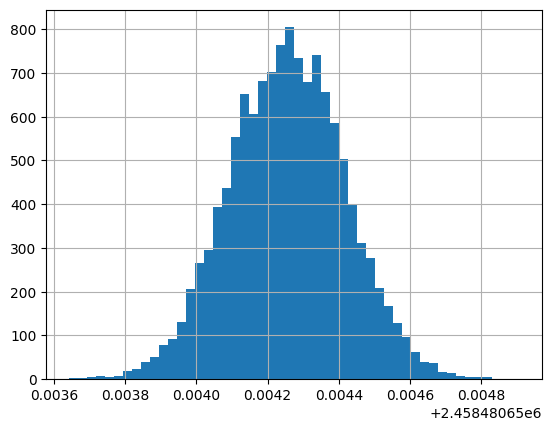

In [46]:
df.tc.hist(bins=50)

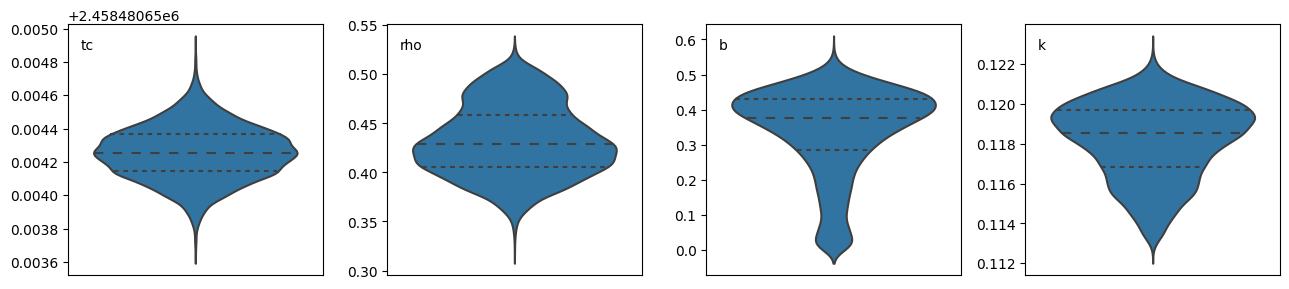

In [47]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

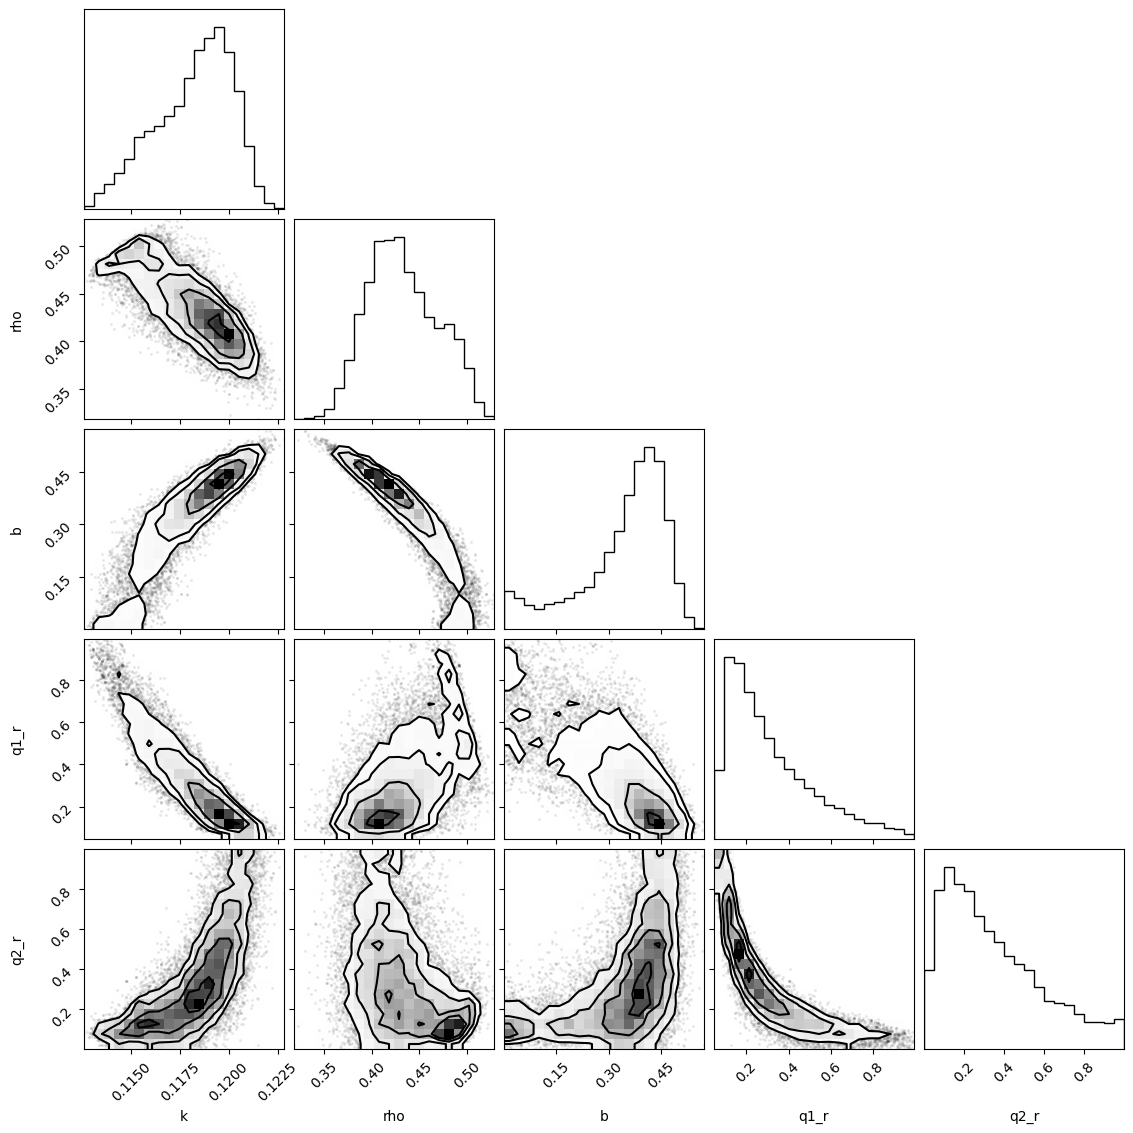

In [48]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols], labels=ccols);

### <span style="color:darkblue">Questions and exercises</span>

1. **Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere ;)) Give the answer in Jupiter radii.**

> The radius of the star WASP-12 given in [L. Hebb et al. (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920/pdf) is $R_\ast = 1.57\ R_\odot = 1093253.8\ Km$. With this information we can proceed with the determination of the radius of the planet:

> $$\texttt{k} = \frac{R_p}{R_\ast} → R_p = \texttt{k} R_\ast$$

> Whose answer is: 
$$ R_p = (1.85 \pm 0.03)\ R_J $$ 
with $R_J = 69911\ Km$ ([Wikipedia](https://es.wikipedia.org/wiki/J%C3%BApiter_(planeta))).

In [49]:
##### RADIUS OF THE PLANET #####

R_s = 1093253.8 #km
R_j = 69911     #km

R_p = df.k*R_s

R_p_m = median(R_p)
R_p_e = std(R_p)

print('The radius of the planet WASP-12b is: (%.4f +- %.4f) Km = (%.4f +- %.4f) R_jup' %(R_p_m, R_p_e, R_p_m/R_j, R_p_e/R_j))

The radius of the planet WASP-12b is: (129583.6945 +- 2114.6548) Km = (1.8536 +- 0.0302) R_jup


2. **Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.**

> The stellar density found in the paper [L. Hebb et al. (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920/pdf) is $\rho_\ast = (0.35 \pm 0.03)\ \rho_\odot$. Knowing that the density of the sun is $\rho_\ast = 1.41\ g/cm^{3}$ ([Wikipedia](https://es.wikipedia.org/wiki/Sol)), we get: $\rho_\ast = (0.49 \pm 0.04)\ g/cm^{3}$. 

> With this model we estimate a value of $\rho_\ast = (0.43 \pm 0.04)\ g/cm^{3}$.

> For a double check we can calculate the stellar density using the bibliography values of WASP-12's mass and radius: $M_\ast = 2.685 \cdot 10^{30}\ kg$ ([Wikipedia](https://es.wikipedia.org/wiki/WASP-12)) and $R_\ast = 1093253.8\ Km$ ([L. Hebb et al. (2009)](https://iopscience.iop.org/article/10.1088/0004-637X/693/2/1920/pdf)). We get:
$$
\rho_\ast = \frac{M\ast}{\frac{4}{3}\pi R_\ast^{3}} = 0.49\ g/cm^{3}
$$

> We can see that the values are equal within the error range.




In [50]:
##### STELLAR DENSITY #####

rho_m = median(df.rho)
rho_e = std(df.rho)

print('The estimated stellar density is: (%.4f +- %.4f) g/cm3' %(rho_m, rho_e))

rho_paper = 0.35*1.41   #g/cm3
rhoe_paper = 0.03*1.41  #g/cm3

print('The stellar density given by L. Hebb et al. is: (%.4f +- %.4f) g/cm3' %(rho_paper, rhoe_paper))

mass_star = 2.685e30  #kg
R_s = 1093253.8       #km

theo_density = mass_star/(4/3*pi*R_s**3)*1e-12

print('The theoretical density is: %.4f g/cm3' %theo_density)

The estimated stellar density is: (0.4287 +- 0.0361) g/cm3
The stellar density given by L. Hebb et al. is: (0.4935 +- 0.0423) g/cm3
The theoretical density is: 0.4906 g/cm3


3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

> What it means is that any change in one of the parameters causes a change in all of the others. 
This means that if one of the parameters has a big error it could affect the other parameters as well, due to error propagation.

---
<center>&copy; Hannu Parviainen 2014&ndash;2023</center>